## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [7]:
calibration_folder = './camera_cal'

### Extracting Points

In [9]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
full_path = calibration_folder + '/calibration*.jpg'
images = glob.glob(full_path)

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()



### Calibrating

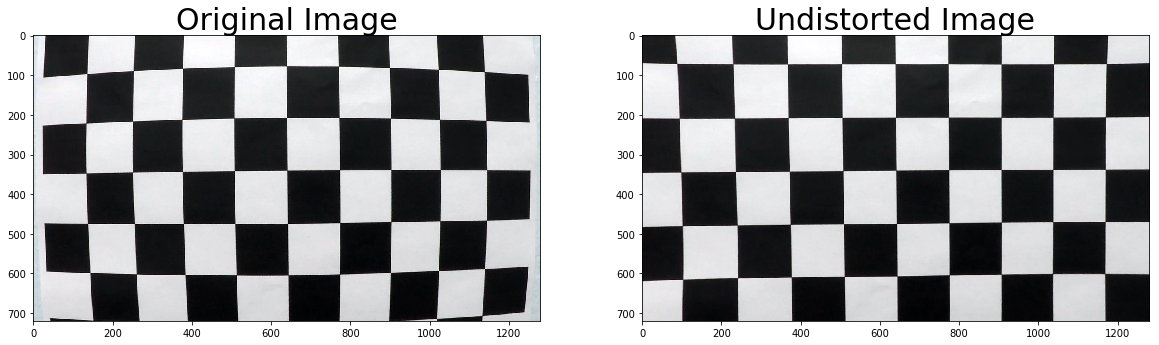

In [10]:
import pickle
%matplotlib inline

# Test undistortion on an image
test_image_path = calibration_folder + '/calibration1.jpg'
img = cv2.imread(test_image_path)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
undistort_path = calibration_folder + '/test_undist.jpg'
cv2.imwrite(undistort_path,dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist

pickle_path = calibration_folder + '/wide_dist_pickle.p'
pickle.dump( dist_pickle, open( pickle_path, "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Lane Detection Pipeline

### Utils

In [23]:
import matplotlib.pyplot as plt

def plot_image(index, img, title, mode = 'RBG', points = []):
    if (mode is 'BGR'):
        aux_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        aux_img = img
    
    plt.figure(index)
    
    if (mode is 'GRAY'):
        plt.imshow(aux_img, cmap='gray')
    else:
        plt.imshow(aux_img)
        
    plt.title(title, fontsize=30)
    
    for p in points:
        x = p[0]
        y = p[1]
        plt.plot(x,y, "o")
    #cv2.imshow(title,aux_img)

### Pipeline

In [24]:
import numpy as np

def undistort_image(distorted_img, camera_matrix, distortion_coeffs):
    return cv2.undistort(distorted_img, camera_matrix, distortion_coeffs, None, camera_matrix)


def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def to_saturation(img, thresh = (90, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return S

def sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    dx = 1
    dy = 0
    if orient == 'y':
        dx = 0
        dy = 1
    
    sobel = cv2.Sobel(img, cv2.CV_64F, dx, dy, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return sxbinary

def sobel_magnitude(img, sobel_kernel=3, mag_thresh=(0, 255)):    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel)
    #abs_sobel = np.absolute(sobelx+sobely)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary = np.zeros_like(scaled_sobel)
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary

def sobel_direction(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def sobel_combined(img):
    ksize = 3
    gradx = sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(30, 255))
    grady = sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(30, 255))
    mag_binary = sobel_magnitude(img, sobel_kernel=ksize, mag_thresh=(30, 255))
    dir_binary = sobel_direction(img, sobel_kernel=15, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[((gradx == 1) & (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((gradx == 1) | (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1


    return combined

def perspective_transform(img, src,dst):
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped;



### Load Test Image

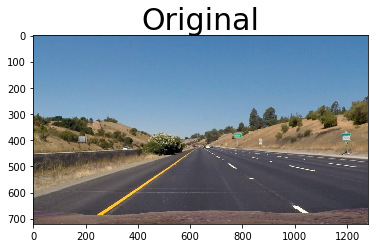

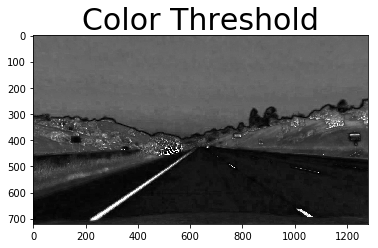

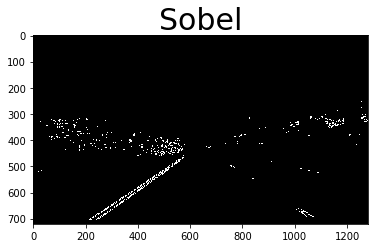

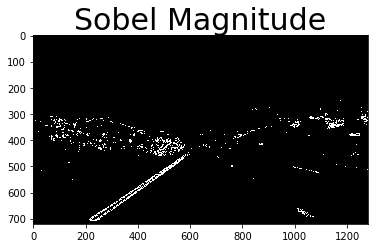

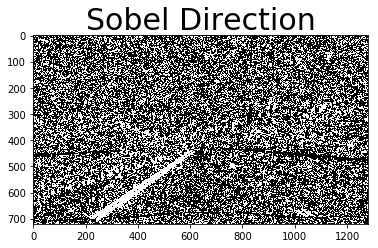

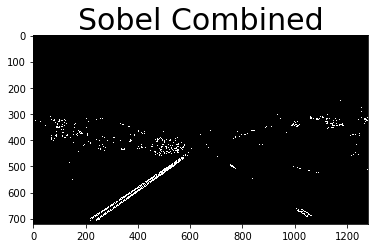

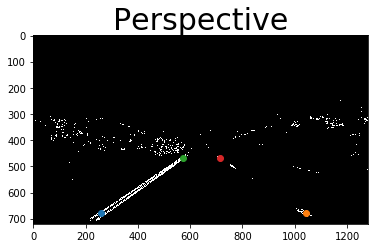

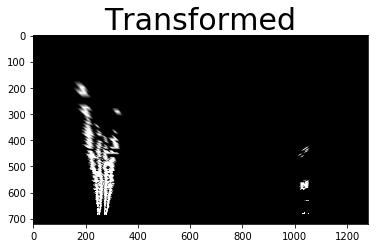

In [28]:
import cv2
import pickle

test_image_folder = './test_images'
test_image_path = test_image_folder + '/straight_lines1.jpg'
test_image = cv2.imread(test_image_path)

calibration_folder = './camera_cal'
pickle_path = calibration_folder + '/wide_dist_pickle.p'
dist_pickle = pickle.load( open( pickle_path, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

plot_image(0,test_image, 'Original', mode = 'BGR')

undistorted_img = undistort_image(test_image, mtx, dist)

plot_image(1,undistorted_img, 'Undistorted', mode = 'BGR')

color_threshold = to_saturation(undistorted_img)
plot_image(1,color_threshold, 'Color Threshold', mode = 'GRAY')

sobel = sobel_thresh(color_threshold, orient='x', sobel_kernel=3, thresh=(30, 100))

plot_image(2,sobel, 'Sobel', mode = 'GRAY')

sobel_mag = sobel_magnitude(color_threshold, sobel_kernel=3, mag_thresh=(30, 100))
plot_image(3,sobel_mag, 'Sobel Magnitude', mode = 'GRAY')


sobel_dir = sobel_direction(color_threshold, sobel_kernel=15, thresh=(0.7, 1.3))
plot_image(4,sobel_dir, 'Sobel Direction', mode = 'GRAY')

sobel_comb = sobel_combined(color_threshold)
plot_image(5,sobel_comb, 'Sobel Combined', mode = 'GRAY')

p = [[260,680],[1042, 680],[571,467],[713,467]]
plot_image(6,sobel_comb, 'Perspective', mode = 'GRAY', points = p)

src = np.float32(p)
dest = np.float32([[260,680],[1042, 680],[260,467],[1042,467]])

perspective_trasformed = perspective_transform(sobel_comb, src, dest)
plot_image(7,perspective_trasformed, 'Transformed', mode = 'GRAY')


